In [3]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the CSV file
CSV_FILE = "./data/newTestingData.csv"  # Replace with your actual file path
df = pd.read_csv(CSV_FILE)

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

# %%
# Data exploration
print("Column names:")
print(df.columns.tolist())
print("\nBasic statistics:")
print(df.describe())

# %%
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Dataset shape: (4205, 18)

First few rows:
Column names:
['CUST_ORDER_ID', 'LOCATION_ID', 'PART_ID', 'TYPE', 'QTY', 'TRANSACTION_DATE', 'CREATE_DATE', 'USER_ID', 'PICK_HOUR', 'DAY_OF_WEEK', 'ZONE', 'AISLE_BIN', 'ORDER_SIZE', 'TOTAL_ORDER_QTY', 'PREV_LOCATION', 'NEXT_LOCATION', 'SECONDS_SINCE_LAST_PICK', 'LOCATION_RANK']

Basic statistics:
            PART_ID          QTY    PICK_HOUR  DAY_OF_WEEK  ORDER_SIZE  \
count  4.205000e+03  4205.000000  4205.000000  4205.000000      4205.0   
mean   1.134877e+09     3.958621    11.987158     4.066825      4205.0   
std    2.098670e+08     6.706409     2.078348     1.342263         0.0   
min    1.010073e+09     1.000000     7.000000     2.000000      4205.0   
25%    1.030096e+09     2.000000    10.000000     3.000000      4205.0   
50%    1.058595e+09     2.000000    12.000000     4.000000      4205.0   
75%    1.095352e+09     4.000000    14.000000     5.000000      4205.0   
max    1.990000e+09   128.000000    17.000000     6.000000      420

Total orders: 777
Average order length: 5.41
Min order length: 1
Max order length: 32


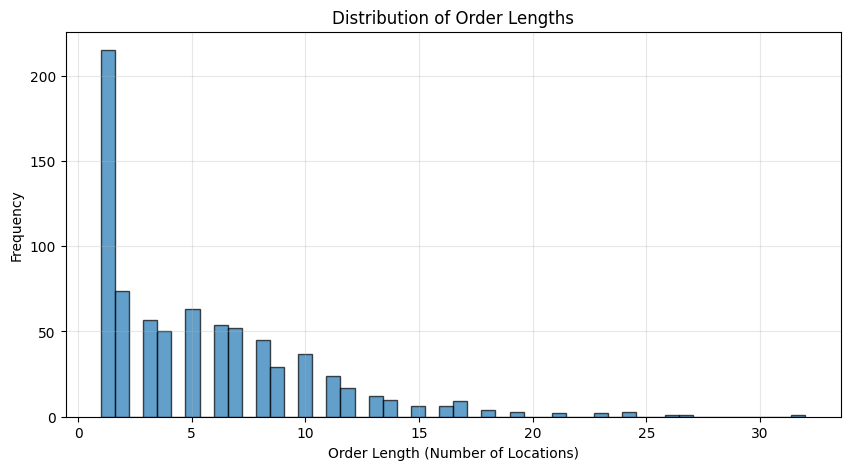

In [5]:
def load_and_prepare_data(dataframe):
    """Load and group by customer order"""
    # Sort by order and location rank
    df_sorted = dataframe.sort_values(['CUST_ORDER_ID', 'LOCATION_RANK'])
    
    # Group by customer order
    order_groups = df_sorted.groupby('CUST_ORDER_ID')['LOCATION_ID'].apply(list).values
    
    print(f"Total orders: {len(order_groups)}")
    print(f"Average order length: {np.mean([len(order) for order in order_groups]):.2f}")
    print(f"Min order length: {min([len(order) for order in order_groups])}")
    print(f"Max order length: {max([len(order) for order in order_groups])}")
    
    return order_groups

order_groups = load_and_prepare_data(df)
# Visualize order length distribution
order_lengths = [len(order) for order in order_groups]

plt.figure(figsize=(10, 5))
plt.hist(order_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Order Length (Number of Locations)')
plt.ylabel('Frequency')
plt.title('Distribution of Order Lengths')
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
def create_vocabulary(order_groups):
    """Create location vocabulary mapping"""
    all_locations = set()
    for order in order_groups:
        all_locations.update(order)
    
    # Create mappings (reserve 0 for padding)
    location_to_idx = {loc: idx + 1 for idx, loc in enumerate(sorted(all_locations))}
    idx_to_location = {idx: loc for loc, idx in location_to_idx.items()}
    
    vocab_size = len(all_locations) + 1
    
    print(f"Vocabulary size: {vocab_size} unique locations")
    print(f"Sample locations: {list(all_locations)[:10]}")
    
    return location_to_idx, idx_to_location, vocab_size

location_to_idx, idx_to_location, vocab_size = create_vocabulary(order_groups)

Vocabulary size: 576 unique locations
Sample locations: ['E8408700', 'F7557501', 'D6396600', 'D6396503', 'G6656702', 'G7697202', 'F6506500', 'F7557400', 'D8358601', 'F8548000']


Created 3428 training sequences


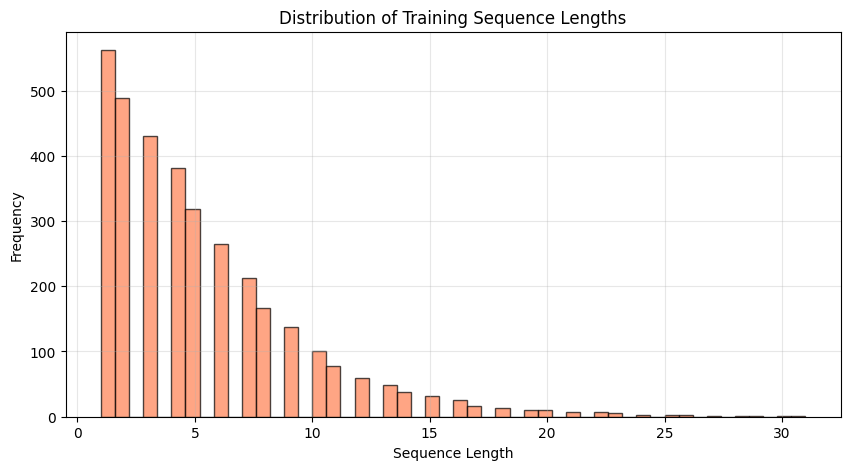

In [7]:
def create_sequences(order_groups, location_to_idx):
    """Create input sequences and targets"""
    sequences = []
    targets = []
    
    for order in order_groups:
        if len(order) < 2:
            continue
        
        # Convert locations to indices
        encoded_order = [location_to_idx[loc] for loc in order]
        
        # Create sequences: use locations [0:i] to predict location [i]
        for i in range(1, len(encoded_order)):
            sequences.append(encoded_order[:i])
            targets.append(encoded_order[i])
    
    print(f"Created {len(sequences)} training sequences")
    
    return sequences, targets

sequences, targets = create_sequences(order_groups, location_to_idx)

# %%
# Visualize sequence length distribution
seq_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(10, 5))
plt.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Training Sequence Lengths')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Pad sequences to fixed length
max_length = 20
X = pad_sequences(sequences, maxlen=max_length, padding='pre')
y = to_categorical(targets, num_classes=vocab_size)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Max sequence length: {max_length}")

# %%
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Input shape: (3428, 20)
Target shape: (3428, 576)
Max sequence length: 20
Training samples: 2742
Testing samples: 686


In [9]:
def build_lstm_model(vocab_size, max_sequence_length, embedding_dim=64, lstm_units=128):
    """Build and compile LSTM model"""
    model = Sequential([
        Embedding(input_dim=vocab_size, 
                 output_dim=embedding_dim, 
                 input_length=max_sequence_length,
                 name='embedding'),
        LSTM(lstm_units, return_sequences=True, name='lstm_1'),
        Dropout(0.3, name='dropout_1'),
        LSTM(lstm_units // 2, name='lstm_2'),
        Dropout(0.3, name='dropout_2'),
        Dense(64, activation='relu', name='dense_1'),
        Dense(vocab_size, activation='softmax', name='output')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_lstm_model(vocab_size, max_length)
model.summary()

x:\Projects\Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.0452 - loss: 5.7832 - val_accuracy: 0.0496 - val_loss: 5.3148
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0773 - loss: 5.2543 - val_accuracy: 0.0496 - val_loss: 5.2861
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0784 - loss: 5.2085 - val_accuracy: 0.0496 - val_loss: 5.2995
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0780 - loss: 5.2007 - val_accuracy: 0.0496 - val_loss: 5.3055
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0784 - loss: 5.1620 - val_accuracy: 0.0496 - val_loss: 5.2670
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0784 - loss: 5.1061 - val_accuracy: 0.0496 - val_loss: 5.2241
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0780 - loss: 5.0704 - val_accuracy: 0.0496 - val_loss: 5.2177
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0788 - loss: 5.0304 - val_accuracy: 0.0496 - v

Test Loss: 5.4812
Test Accuracy: 0.0641


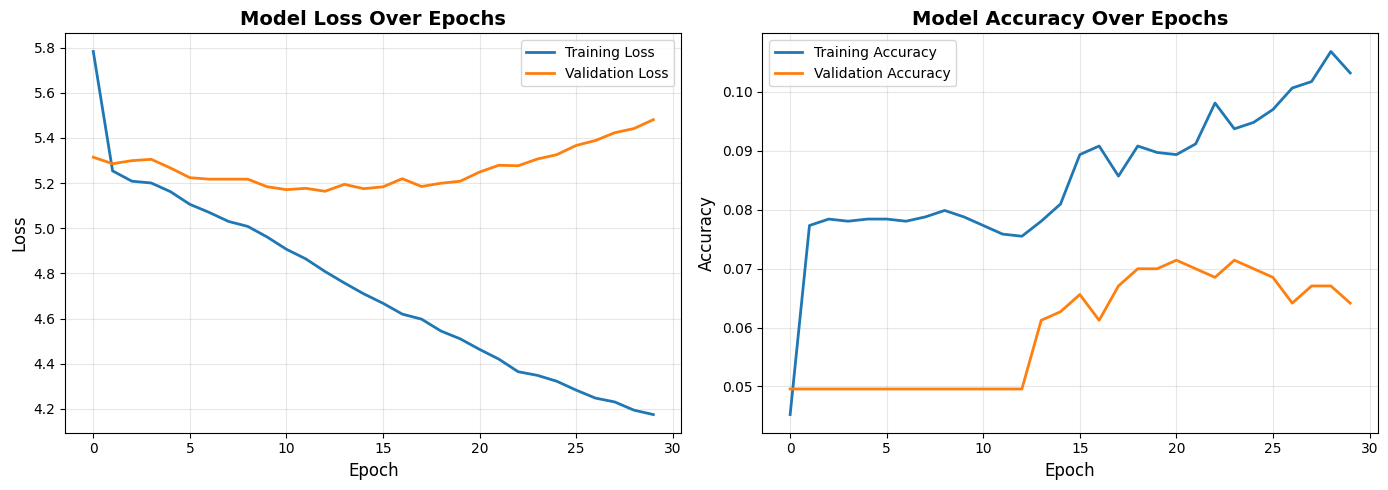

Training history plot saved as 'training_history.png'


In [11]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# %%
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history.png'")

In [12]:
def predict_next_locations(model, sequence, location_to_idx, idx_to_location, 
                          max_length, top_k=5):
    """Predict top-k next locations given a sequence"""
    # Encode sequence
    encoded = [location_to_idx.get(loc, 0) for loc in sequence]
    
    # Pad sequence
    padded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    
    # Predict
    predictions = model.predict(padded, verbose=0)[0]
    
    # Get top-k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        if idx in idx_to_location:
            results.append({
                'location': idx_to_location[idx],
                'probability': predictions[idx]
            })
    
    return results

Input sequence: ['E6496600']

Top 5 predicted next locations:
1. E4000000: 14.26%
2. D4000000: 5.53%
3. C4000000: 4.77%
4. E5465900: 4.59%
5. F5545600: 4.01%


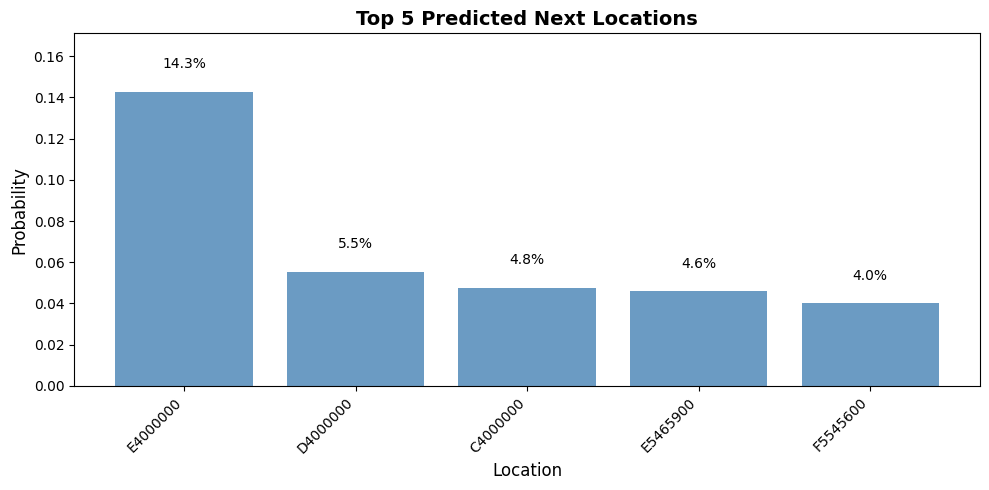

In [13]:
# Test on a sample order
example_order = order_groups[0][:5]
print(f"Input sequence: {example_order}")

predictions = predict_next_locations(
    model, example_order, location_to_idx, 
    idx_to_location, max_length, top_k=5
)

print("\nTop 5 predicted next locations:")
for i, pred in enumerate(predictions, 1):
    print(f"{i}. {pred['location']}: {pred['probability']:.2%}")

# %%
# Visualize predictions
locations = [pred['location'] for pred in predictions]
probabilities = [pred['probability'] for pred in predictions]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(locations)), probabilities, color='steelblue', alpha=0.8)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Top 5 Predicted Next Locations', fontsize=14, fontweight='bold')
plt.xticks(range(len(locations)), locations, rotation=45, ha='right')
plt.ylim(0, max(probabilities) * 1.2)

# Add value labels on bars
for i, (bar, prob) in enumerate(zip(bars, probabilities)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
# Test on multiple random orders
print("Testing on 5 random orders:")
print("=" * 80)

np.random.seed(42)
test_indices = np.random.choice(len(order_groups), size=5, replace=False)

for idx in test_indices:
    order = order_groups[idx]
    if len(order) < 3:
        continue
    
    seq_len = min(5, len(order) - 1)
    input_seq = order[:seq_len]
    actual_next = order[seq_len]
    
    predictions = predict_next_locations(
        model, input_seq, location_to_idx, 
        idx_to_location, max_length, top_k=3
    )
    
    print(f"\nInput: {input_seq}")
    print(f"Actual next: {actual_next}")
    print("Predictions:")
    for i, pred in enumerate(predictions, 1):
        match = "✓" if pred['location'] == actual_next else ""
        print(f"  {i}. {pred['location']}: {pred['probability']:.2%} {match}")
    print("-" * 80)

Testing on 5 random orders:

Input: ['C4000000', 'E6496903', 'F6506702', 'F6506600']
Actual next: D7347100
Predictions:
  1. D7307300: 3.61% 
  2. D7357900: 2.45% 
  3. D7307900: 2.25% 
--------------------------------------------------------------------------------

Input: ['G6656300', 'G6656400', 'G7657500', 'D4000000', 'D7307800']
Actual next: D7347100
Predictions:
  1. D7347100: 4.52% ✓
  2. D7307300: 3.19% 
  3. D6346400: 2.58% 
--------------------------------------------------------------------------------

Input: ['C4000000', 'E5465700', 'E5465900', 'E4000000', 'E6406500']
Actual next: E6406100
Predictions:
  1. F5505600: 9.90% 
  2. E6406100: 7.46% ✓
  3. E4000000: 7.37% 
--------------------------------------------------------------------------------

Input: ['E4000000', 'D6000000', 'C4000000', 'D5000000', 'B4000000']
Actual next: D7357900
Predictions:
  1. D6000000: 15.03% 
  2. E5000000: 12.57% 
  3. D5000000: 11.25% 
--------------------------------------------------------

In [ ]:
# Save the trained model
model.save('./models/lstm_location_model.keras')
print("Model saved to 'lstm_location_model.keras'")

# %%
# Save vocabulary and metadata
model_artifacts = {
    'location_to_idx': location_to_idx,
    'idx_to_location': idx_to_location,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'test_accuracy': accuracy,
    'test_loss': loss
}

with open('./models/model_artifacts.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("Model artifacts saved to 'model_artifacts.pkl'")

# %%
# Save training history
history_dict = {
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
}

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

print("Training history saved to 'training_history.pkl'")

Model saved to 'lstm_location_model.keras'
Model artifacts saved to 'model_artifacts.pkl'
Training history saved to 'training_history.pkl'


In [16]:
# Example: How to load the model later
def load_trained_model():
    """Load the saved model and artifacts"""
    # Load model
    loaded_model = load_model('lstm_location_model.keras')
    
    # Load artifacts
    with open('model_artifacts.pkl', 'rb') as f:
        artifacts = pickle.load(f)
    
    print("Model and artifacts loaded successfully!")
    print(f"Vocabulary size: {artifacts['vocab_size']}")
    print(f"Max sequence length: {artifacts['max_length']}")
    print(f"Test accuracy: {artifacts['test_accuracy']:.4f}")
    
    return loaded_model, artifacts

# Uncomment to test loading
# loaded_model, artifacts = load_trained_model()

In [17]:
print("=" * 80)
print("MODEL SUMMARY")
print("=" * 80)
print(f"Total unique locations: {vocab_size - 1}")
print(f"Total training sequences: {len(sequences)}")
print(f"Max sequence length: {max_length}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nFinal Test Accuracy: {accuracy:.4f}")
print(f"Final Test Loss: {loss:.4f}")
print("\nSaved files:")
print("  - lstm_location_model.keras")
print("  - model_artifacts.pkl")
print("  - training_history.pkl")
print("  - training_history.png")
print("=" * 80)

MODEL SUMMARY
Total unique locations: 575
Total training sequences: 3428
Max sequence length: 20
Training samples: 2742
Test samples: 686

Final Test Accuracy: 0.0641
Final Test Loss: 5.4812

Saved files:
  - lstm_location_model.keras
  - model_artifacts.pkl
  - training_history.pkl
  - training_history.png
